---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS

2020a_SSH_mapping_NATL60_DUACS_en_j1_tpn_g2.nc	     ssh_DUACS_swot_4nadir.nc
2020a_SSH_mapping_NATL60_DUACS_swot_en_j1_tpn_g2.nc  ssh_DUACS_swot.nc
ssh_DUACS_4nadir.nc


In [5]:
# !cat configs/postprocess.yaml

In [6]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

In [7]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units

In [8]:
def calculate_physical_quantities(da):
    da["ssh"] = da.ssh * units.meters
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [9]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [10]:
%%time

# load config
config_dm = OmegaConf.load('./configs/postprocess.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 12.9 s, sys: 2.69 s, total: 15.6 s
Wall time: 47.6 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

#### AlongTrack -> Uniform Grid

In [11]:
# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())

## Coarsend Versions

In [12]:
ds_natl60 = ds_natl60.coarsen({"lon": 3, "lat": 3}).mean()
ds_natl60

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat      (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.652 0.6585 0.6642 ... -0.2079 -0.2149
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets 

In [61]:
%%time

# load config

experiment = "swot" #  "nadir" # 
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_nadir.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_swot.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_SWOT.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 169 ms, sys: 45.3 ms, total: 214 ms
Wall time: 434 ms


In [62]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

nadir1.nc  nadir4.nc  nadir5.nc  swot1nadir5.nc  swot.nc


## Regrdding

#### Uniform Grid --> Uniform Grid

In [63]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 10.3 s, sys: 95.6 ms, total: 10.4 s
Wall time: 10.4 s


### Preprocess Chain

In [64]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_mlp.pint.dequantify())


CPU times: user 1.01 s, sys: 872 µs, total: 1.01 s
Wall time: 1.01 s


## Geophysical Variables

In [65]:
def calculate_physical_quantities(da):
    da["ssh"] = da.ssh * units.meters
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [66]:
%%time

ds_natl60 = calculate_physical_quantities(correct_labels(ds_natl60).pint.dequantify())
ds_duacs = calculate_physical_quantities(correct_labels(ds_duacs).pint.dequantify())
ds_miost = calculate_physical_quantities(correct_labels(ds_miost).pint.dequantify())
ds_nerf_siren = calculate_physical_quantities(correct_labels(ds_nerf_siren).pint.dequantify())
ds_nerf_ffn = calculate_physical_quantities(correct_labels(ds_nerf_ffn).pint.dequantify())
ds_nerf_mlp = calculate_physical_quantities(correct_labels(ds_nerf_mlp).pint.dequantify())

CPU times: user 3.26 s, sys: 123 ms, total: 3.38 s
Wall time: 3.4 s


## Absolute Statistics

In [196]:
from matplotlib import ticker

def absolute_error_plot(da, da_ref, variable="ssh", color="red"):
    
    r2 = xskillscore.r2(da[variable].pint.dequantify(), da_ref[variable].pint.dequantify(), dim=["lat", "lon", "time"])
    slope = xskillscore.linslope(da[variable].pint.dequantify(), da_ref[variable].pint.dequantify(), dim=["lat", "lon","time"])
    nrmse = nrmse_da(da=da, da_ref=da_ref, variable=variable, dim=["lon", "lat", "time"])
    nrmse_std = nrmse_da(da=da, da_ref=da_ref, variable=variable, dim=["lon", "lat"]).std()

    from matplotlib.offsetbox import AnchoredText

    fig, ax = plt.subplots(figsize=(7,7))
    id_line = np.linspace(-0.75, 1.25)

    xmin = 1.2 * da_ref[variable].min()
    xmax = 1.05 * da_ref[variable].max()

    ax.scatter(x=da[variable].values.ravel(), y=da_ref[variable].values.ravel(), s=0.1, alpha=0.1, color=color)
    ax.plot(id_line, id_line, color="black", zorder=2, linewidth=5)
    ax.set(
        xlim=[xmin, xmax],
        ylim=[xmin, xmax],
        xlabel="Predictions",
        ylabel="Ground Truth",
    )
    # ax.autoscale(enable=True, axis='both', tight=True)
    ax.set_aspect('equal')

    at = AnchoredText(
        f"R$^2$: {r2.values:.3f}" +
        f"\nSlope: {slope.values:.3f}"+
        f"\nnRMSE($\mu$): {nrmse.values:.2f}"+
        f"\nnRMSE($\sigma$): {nrmse_std.values:.2f}",
        prop=dict(fontsize=16), 
        frameon=True,
        loc='upper left',
    )

    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.grid("on", which="both", axis="both", alpha=0.5)
    
    # tick format
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    
    # tick locator
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))

    plt.tight_layout()
    
    return fig, ax

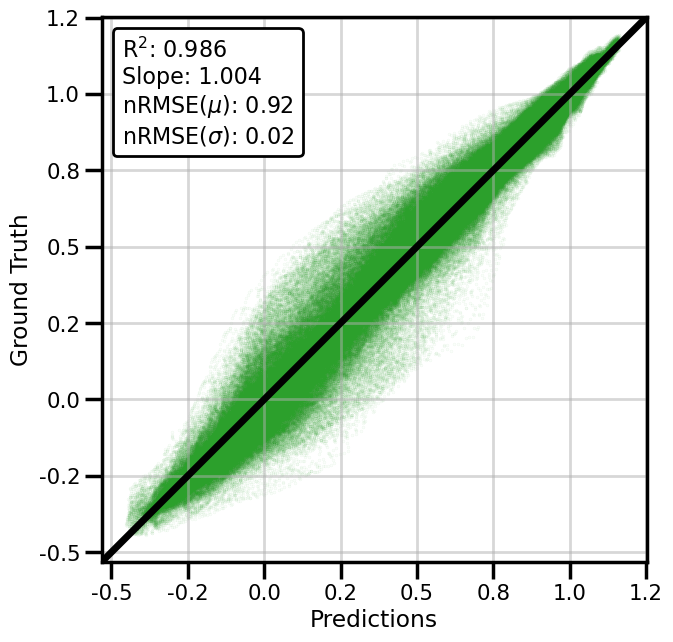

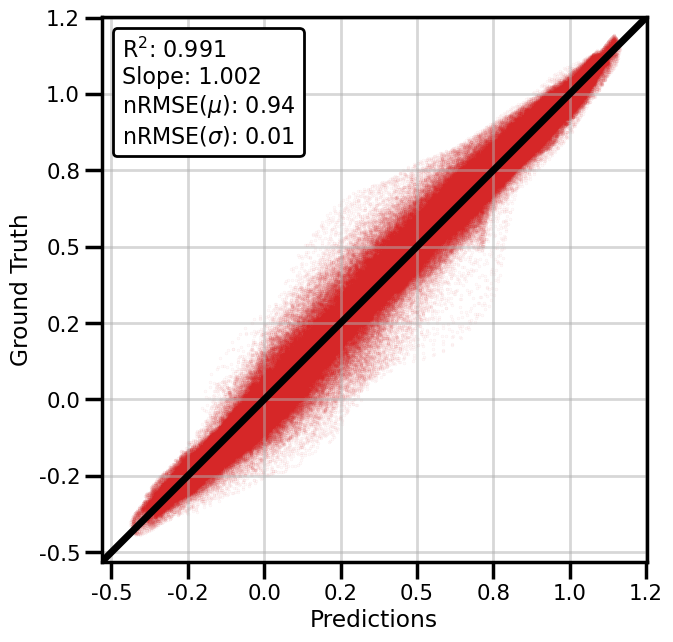

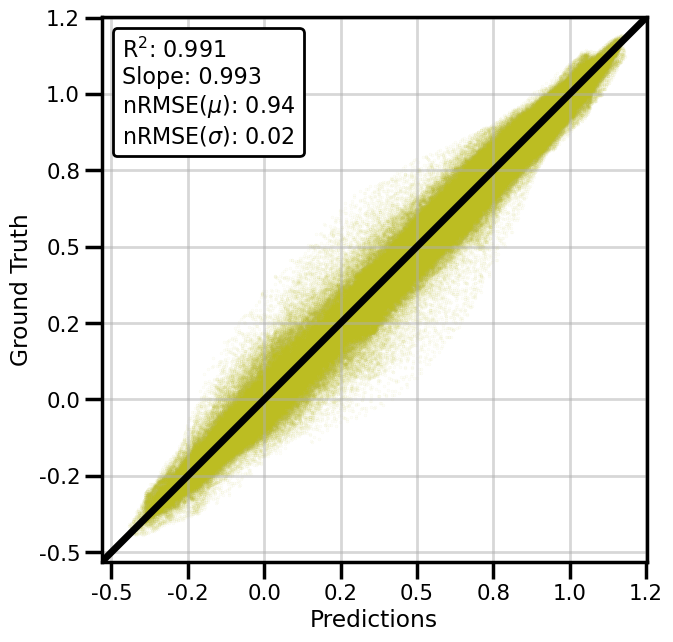

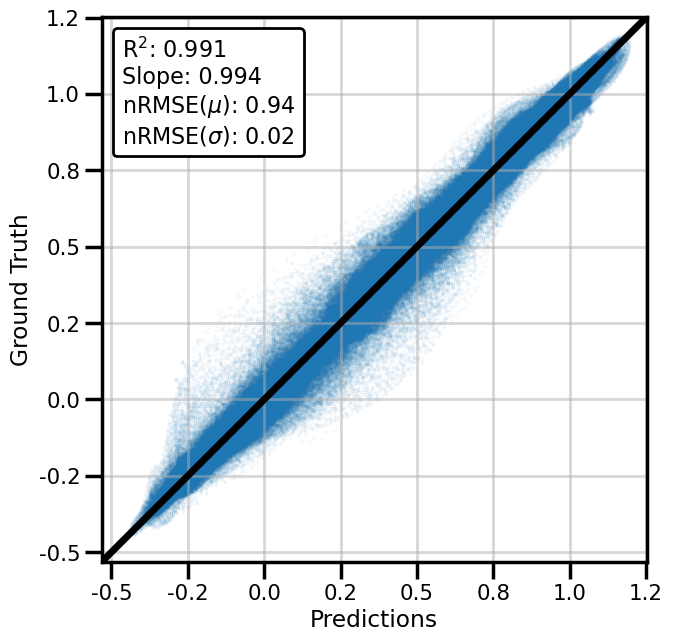

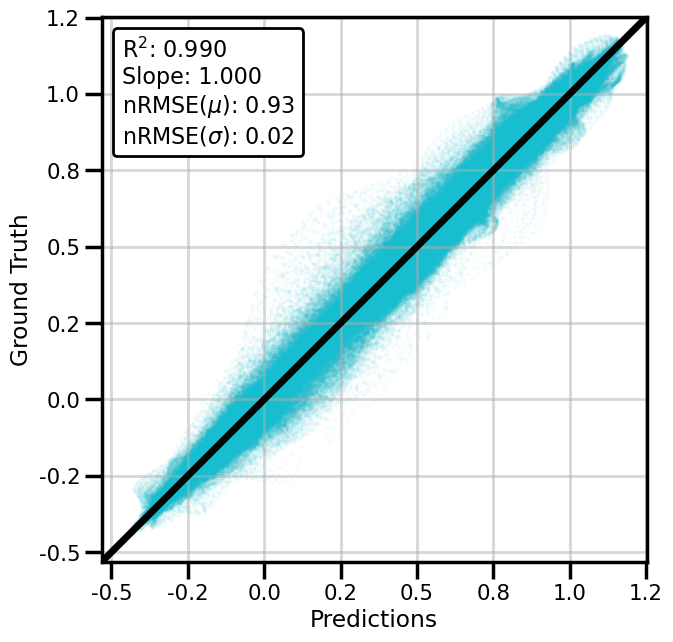

In [197]:
# DUACS
fig, ax = absolute_error_plot(ds_duacs, ds_natl60, "ssh", color="tab:green")
fig.savefig(f"./figures/dc20a/stats/error_duacs_{experiment}.png")

# MIOST
fig, ax = absolute_error_plot(ds_miost, ds_natl60, "ssh", color="tab:red")
fig.savefig(f"./figures/dc20a/stats/error_miost_{experiment}.png")

# NERF (MLP)
fig, ax = absolute_error_plot(ds_nerf_mlp, ds_natl60, "ssh", color="tab:olive")
fig.savefig(f"./figures/dc20a/stats/error_nerf_mlp_{experiment}.png")

# NERF (FFN)
fig, ax = absolute_error_plot(ds_nerf_ffn, ds_natl60, "ssh", color="tab:blue")
fig.savefig(f"./figures/dc20a/stats/error_nerf_ffn_{experiment}.png")

# NERF (SIREN)
fig, ax = absolute_error_plot(ds_nerf_siren, ds_natl60, "ssh", color="tab:cyan")
fig.savefig(f"./figures/dc20a/stats/error_nerf_siren_{experiment}.png")

## Temporal Statistics

In [199]:
from oceanbench._src.metrics.stats import nrmse_da, rmse_da

In [221]:
ds_duacs_nrmse = rmse_da(da=ds_duacs, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_miost_nrmse = rmse_da(da=ds_miost, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_nerf_mlp_nrmse = rmse_da(da=ds_nerf_mlp, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_nerf_ffn_nrmse = rmse_da(da=ds_nerf_ffn, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_nerf_siren_nrmse = rmse_da(da=ds_nerf_siren, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])

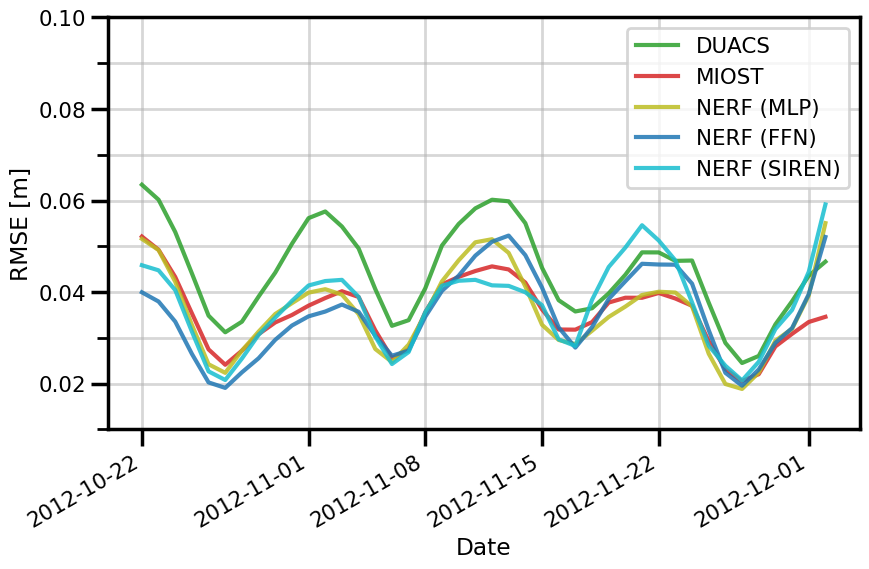

In [227]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_nrmse.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_nrmse.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_nrmse.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_nrmse.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_nrmse.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.01, 0.100],
    ylabel="RMSE [m]",
    xlabel="Date"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/rmse_space_{experiment}.png")
plt.show()

In [215]:
ds_duacs_nrmse = nrmse_da(da=ds_duacs, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_miost_nrmse = nrmse_da(da=ds_miost, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_nerf_mlp_nrmse = nrmse_da(da=ds_nerf_mlp, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_nerf_ffn_nrmse = nrmse_da(da=ds_nerf_ffn, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])
ds_nerf_siren_nrmse = nrmse_da(da=ds_nerf_siren, da_ref=ds_natl60, variable="ssh", dim=["lon", "lat"])

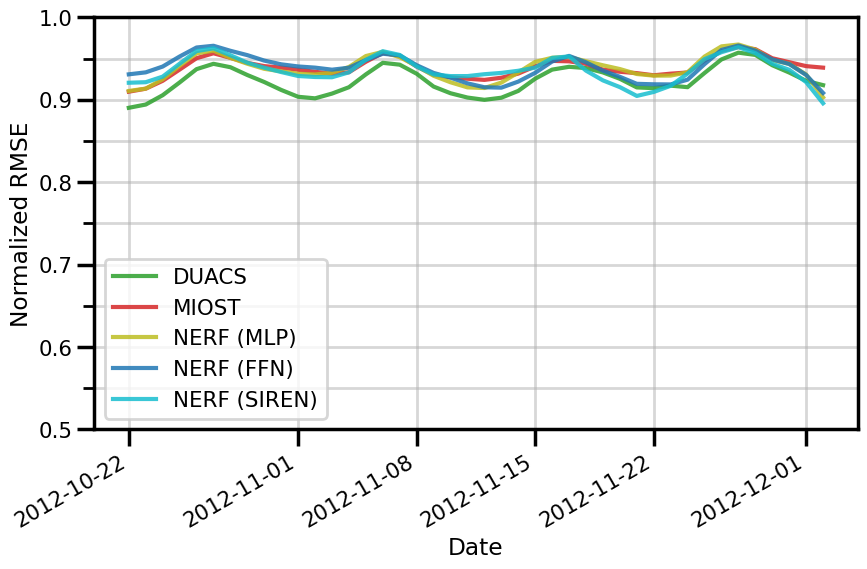

In [219]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_nrmse.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_nrmse.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_nrmse.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_nrmse.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_nrmse.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.5, 1.0],
    ylabel="Normalized RMSE",
    xlabel="Date"
)
ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/nrmse_space_{experiment}.png")
plt.show()

In [228]:
ds_duacs_nrmse = nrmse_da(da=ds_duacs, da_ref=ds_natl60, variable="ssh", dim=["time", "lon"])
ds_miost_nrmse = nrmse_da(da=ds_miost, da_ref=ds_natl60, variable="ssh", dim=["time", "lon"])
ds_nerf_mlp_nrmse = nrmse_da(da=ds_nerf_mlp, da_ref=ds_natl60, variable="ssh", dim=["time", "lon"])
ds_nerf_ffn_nrmse = nrmse_da(da=ds_nerf_ffn, da_ref=ds_natl60, variable="ssh", dim=["time", "lon"])
ds_nerf_siren_nrmse = nrmse_da(da=ds_nerf_siren, da_ref=ds_natl60, variable="ssh", dim=["time", "lon"])

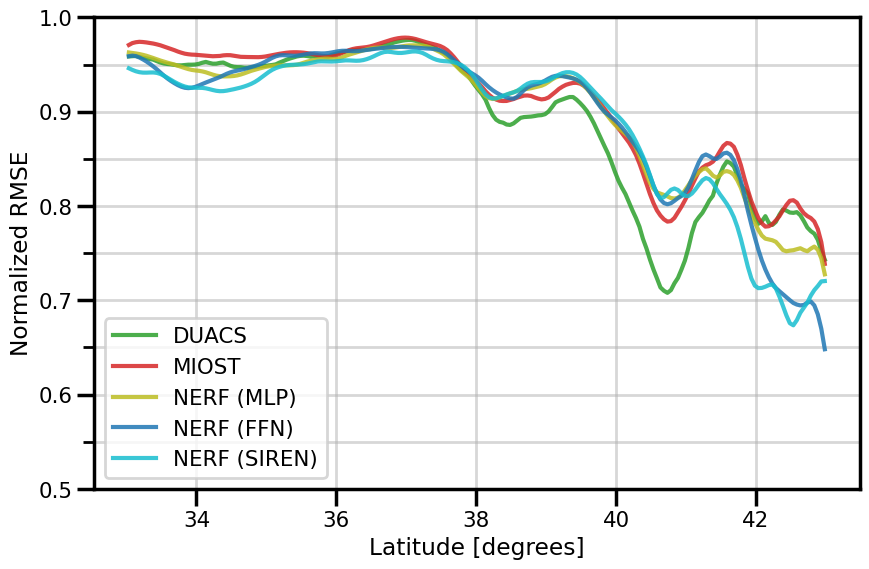

In [230]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_nrmse.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_nrmse.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_nrmse.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_nrmse.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_nrmse.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.5, 1.0],
    ylabel="Normalized RMSE",
    xlabel="Latitude [degrees]"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/nrmse_spacetime_{experiment}.png")
plt.show()

## Higher Level Statistics

In [231]:
from hyppo.independence import RV, Dcorr, Hsic
from hyppo.d_variate import dHsic
from hyppo.ksample import Energy

In [232]:
import xskillscore

In [233]:
def hyppo_fn_pixel(f):
    
    def fn(x, y):
        return f(x.flatten()[:, None], y.flatten()[:, None])
    return fn

def hyppo_fn_2D(f):
    
    def fn(x, y):
        return f(x, y)
    return fn

## Pearson

### Temporal

In [234]:
ds_duacs_pearsonr = xskillscore.pearson_r(ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_miost_pearsonr = xskillscore.pearson_r(ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_nerf_mlp_pearsonr = xskillscore.pearson_r(ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_nerf_ffn_pearsonr = xskillscore.pearson_r(ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_nerf_siren_pearsonr = xskillscore.pearson_r(ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])


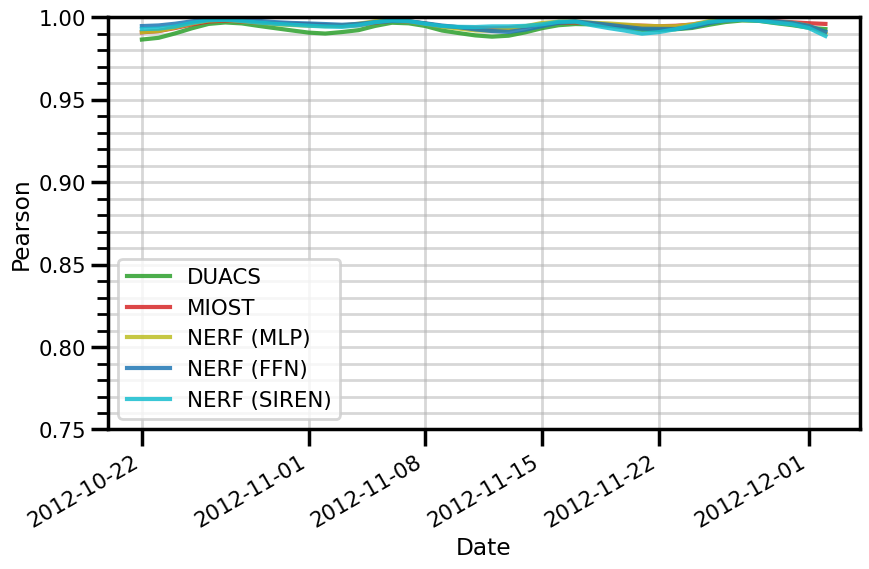

In [241]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_pearsonr.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_pearsonr.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_pearsonr.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_pearsonr.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_pearsonr.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.75, 1.0],
    ylabel="Pearson",
    xlabel="Date"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/pearson_space_{experiment}.png")
plt.show()

In [242]:
ds_duacs_pearsonr = xskillscore.pearson_r(ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_miost_pearsonr = xskillscore.pearson_r(ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_nerf_mlp_pearsonr = xskillscore.pearson_r(ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_nerf_ffn_pearsonr = xskillscore.pearson_r(ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_nerf_siren_pearsonr = xskillscore.pearson_r(ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])


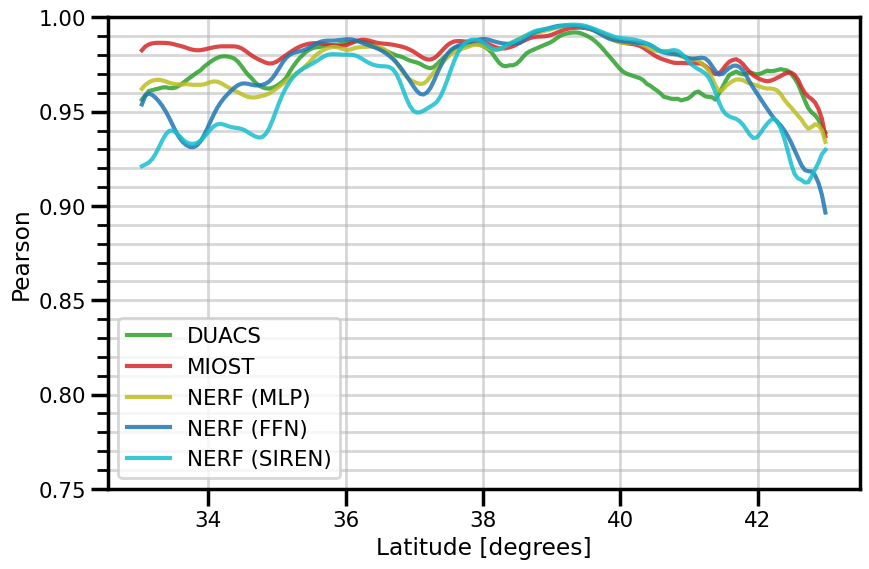

In [244]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_pearsonr.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_pearsonr.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_pearsonr.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_pearsonr.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_pearsonr.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.75, 1.0],
    ylabel="Pearson",
    xlabel="Latitude [degrees]"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/nrmse_spacetime_{experiment}.png")
plt.show()

## Spearman

### Temporal

In [245]:
ds_duacs_pearsonr = xskillscore.spearman_r(ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_miost_pearsonr = xskillscore.spearman_r(ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_nerf_mlp_pearsonr = xskillscore.spearman_r(ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_nerf_ffn_pearsonr = xskillscore.spearman_r(ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])
ds_nerf_siren_pearsonr = xskillscore.spearman_r(ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["lat", "lon"])


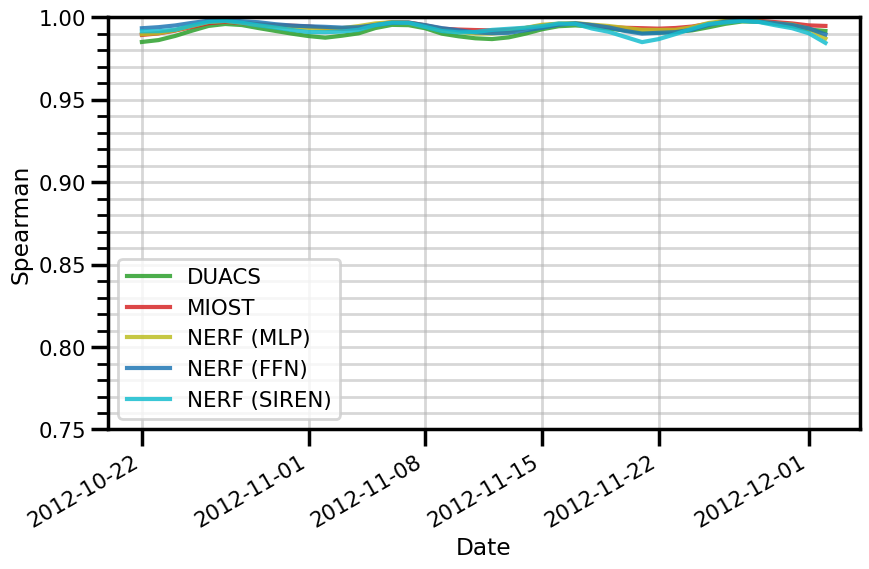

In [247]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_pearsonr.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_pearsonr.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_pearsonr.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_pearsonr.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_pearsonr.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.75, 1.0],
    ylabel="Spearman",
    xlabel="Date"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/spearman_space_{experiment}.png")
plt.show()

In [248]:
ds_duacs_pearsonr = xskillscore.spearman_r(ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_miost_pearsonr = xskillscore.spearman_r(ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_nerf_mlp_pearsonr = xskillscore.spearman_r(ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_nerf_ffn_pearsonr = xskillscore.spearman_r(ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])
ds_nerf_siren_pearsonr = xskillscore.spearman_r(ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(), dim=["time", "lon"])


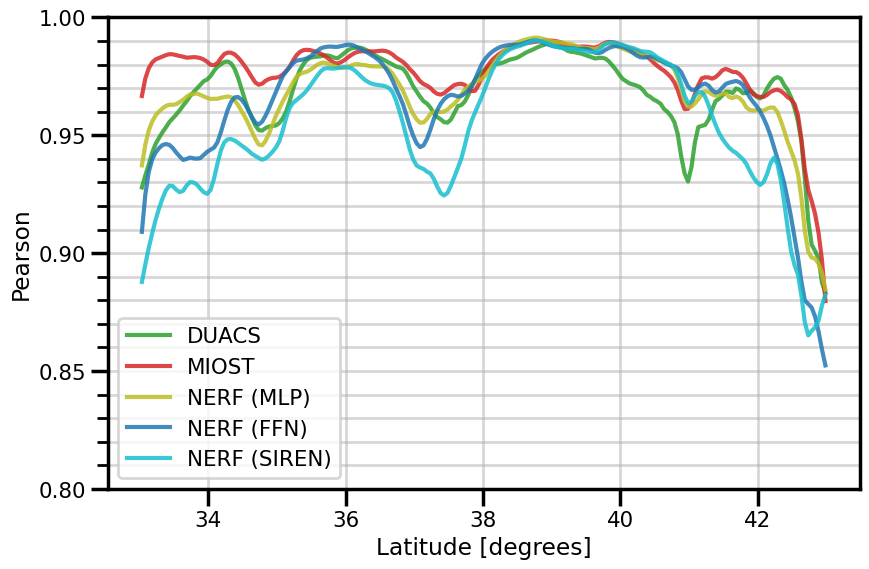

In [251]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_pearsonr.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_pearsonr.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_pearsonr.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_pearsonr.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_pearsonr.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.80, 1.0],
    ylabel="Pearson",
    xlabel="Latitude [degrees]"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/spearman_spacetime_{experiment}.png")
plt.show()

### RV Coefficient

In [252]:
def rv_coefficient(x, y):
    return RV().statistic(x,y)

In [253]:
ds_duacs_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_miost_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_mlp_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_ffn_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_siren_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)

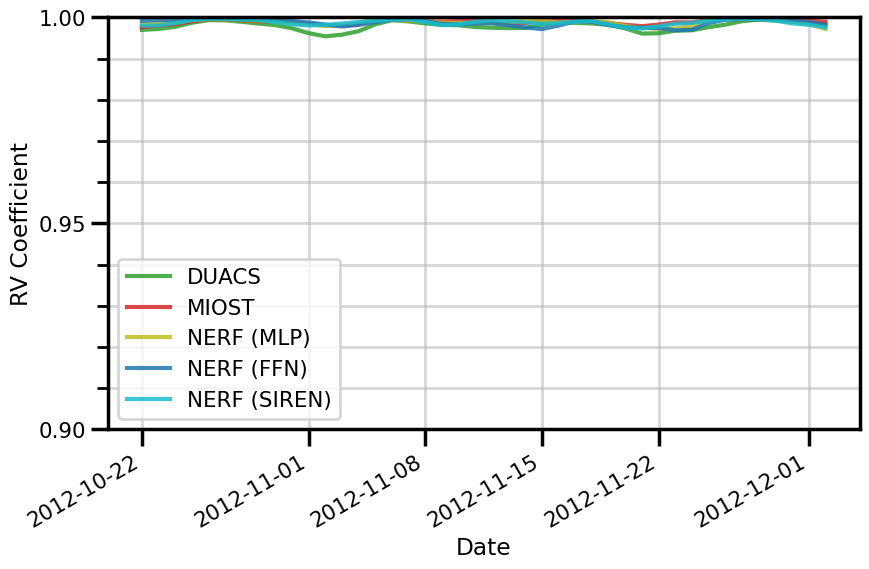

In [255]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_rv.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_rv.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_rv.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_rv.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_rv.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.90, 1.0],
    ylabel="RV Coefficient",
    xlabel="Date"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/rv_space_{experiment}.png")
plt.show()

In [256]:
ds_duacs_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_miost_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_mlp_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_ffn_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_siren_rv = xr.apply_ufunc(
    rv_coefficient,
    ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)

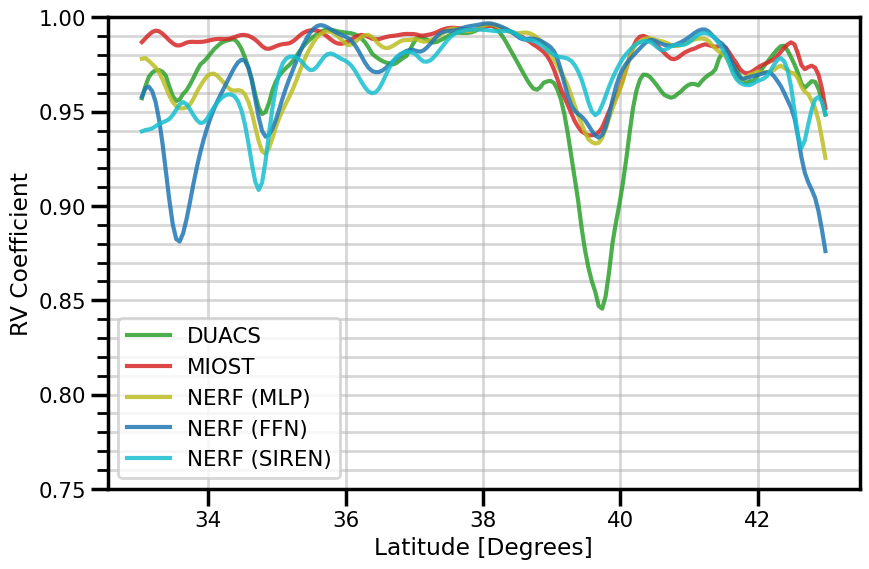

In [259]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_rv.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_rv.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_rv.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_rv.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_rv.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.75, 1.0],
    ylabel="RV Coefficient",
    xlabel="Latitude [Degrees]"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/rv_spacetime_{experiment}.png")
plt.show()

## CKA - Linear

In [260]:
def cka_linear(x, y):
    xy = dHsic(compute_kernel="linear").statistic(x,y)
    xx = dHsic(compute_kernel="linear").statistic(x,x)
    yy = dHsic(compute_kernel="linear").statistic(y,y)
    return xy / (np.sqrt(xx) * np.sqrt(yy))

In [261]:
ds_duacs_rv = xr.apply_ufunc(
    cka_linear,
    ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_miost_rv = xr.apply_ufunc(
    cka_linear,
    ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_mlp_rv = xr.apply_ufunc(
    cka_linear,
    ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_ffn_rv = xr.apply_ufunc(
    cka_linear,
    ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_siren_rv = xr.apply_ufunc(
    cka_linear,
    ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    exclude_dims=set(("lat","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)

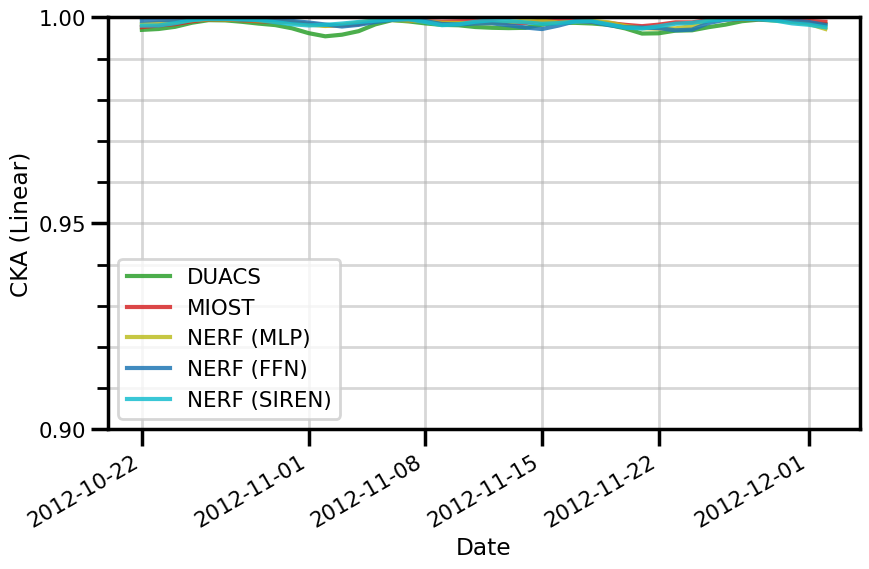

In [263]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_rv.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_rv.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_rv.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_rv.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_rv.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.90, 1.0],
    ylabel="CKA (Linear)",
    xlabel="Date"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))


plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/cka_linear_space_{experiment}.png")
plt.show()

In [264]:
ds_duacs_rv = xr.apply_ufunc(
    cka_linear,
    ds_duacs.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_miost_rv = xr.apply_ufunc(
    cka_linear,
    ds_miost.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_mlp_rv = xr.apply_ufunc(
    cka_linear,
    ds_nerf_mlp.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_ffn_rv = xr.apply_ufunc(
    cka_linear,
    ds_nerf_ffn.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)
ds_nerf_siren_rv = xr.apply_ufunc(
    cka_linear,
    ds_nerf_siren.ssh.pint.dequantify(), ds_natl60.ssh.pint.dequantify(),
    input_core_dims=[["time", "lon"], ["time", "lon"]],
    exclude_dims=set(("time","lon")),
    output_dtypes=[np.float64],
    vectorize=True
)

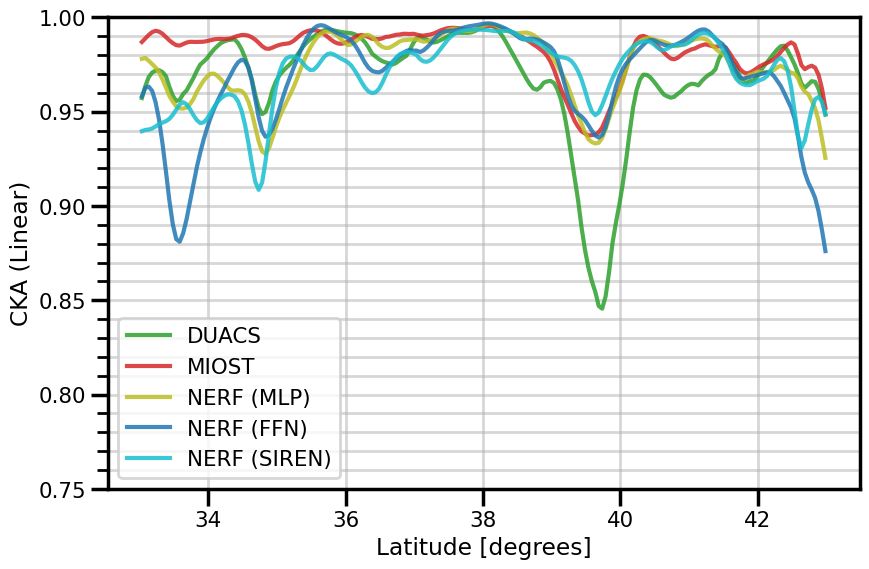

In [266]:
fig, ax = plt.subplots(figsize=(9,6))

ds_duacs_rv.plot(ax=ax, label="DUACS", color="tab:green", alpha=0.85)
ds_miost_rv.plot(ax=ax, label="MIOST", color="tab:red", alpha=0.85)
ds_nerf_mlp_rv.plot(ax=ax, label="NERF (MLP)", color="tab:olive", alpha=0.85)
ds_nerf_ffn_rv.plot(ax=ax, label="NERF (FFN)", color="tab:blue", alpha=0.85)
ds_nerf_siren_rv.plot(ax=ax, label="NERF (SIREN)", color="tab:cyan", alpha=0.85)

ax.set(
    ylim=[0.75, 1.0],
    ylabel="CKA (Linear)",
    xlabel="Latitude [degrees]"
)

ax.grid("on", which="both", axis="both", alpha=0.5)

# tick format
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))

# tick locator
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/stats/cka_spacetime_{experiment}.png")
plt.show()